In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
# get Euro USD from Yahoo Finance

data =  yf.download(
            tickers = 'EURUSD=X',
            period = '5y',
            interval = "1d",
            group_by = 'ticker',
            auto_adjust = True,
            prepost = False,
            threads = True,
            proxy = None
        )

[*********************100%***********************]  1 of 1 completed


In [3]:
adf_result = adfuller(data['Close'], regression='ctt')
# Assigning the values to variables for clarity
test_statistic = adf_result[0]
p_value = adf_result[1]
used_lag = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]
ic_best = adf_result[5]

# Printing the results
print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)
print("Number of Lags Used:", used_lag)
print("Number of Observations:", n_obs)
print("Critical Values:", critical_values)
print("Maximized Information Criterion:", ic_best)

ADF Test Statistic: -1.90697098220987
p-value: 0.8500412991715871
Number of Lags Used: 0
Number of Observations: 1303
Critical Values: {'1%': -4.380044724782124, '5%': -3.836929796807653, '10%': -3.556071741826655}
Maximized Information Criterion: -9910.86615275166


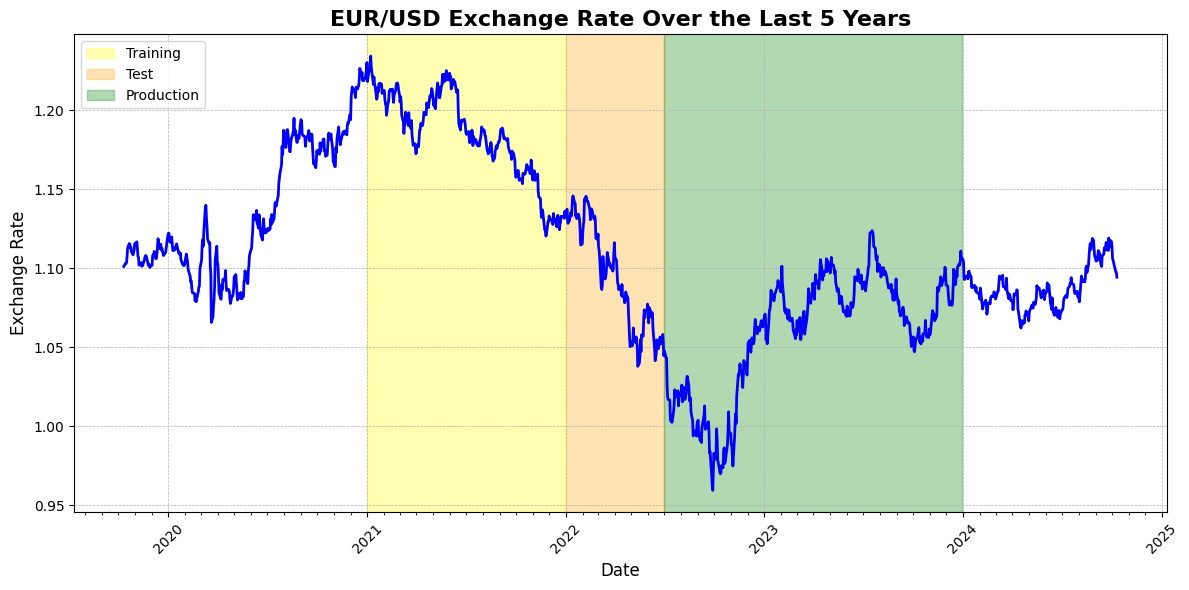

In [4]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].index, data['Close'], color='blue', linewidth=2)

# Highlighting the years and periods
plt.axvspan(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-31'), color='yellow', alpha=0.3, label='Training')
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-06-30'), color='orange', alpha=0.3, label='Test')
plt.axvspan(pd.Timestamp('2022-07-01'), pd.Timestamp('2023-12-31'), color='green', alpha=0.3, label='Production')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add titles and labels
plt.title('EUR/USD Exchange Rate Over the Last 5 Years', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Customize gridlines and ticks
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
temp_data = data['Close'].diff().dropna()

adf_result = adfuller(temp_data, regression='ctt')
# Assigning the values to variables for clarity
test_statistic = adf_result[0]
p_value = adf_result[1]
used_lag = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]
ic_best = adf_result[5]

# Printing the results
print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)
print("Number of Lags Used:", used_lag)
print("Number of Observations:", n_obs)
print("Critical Values:", critical_values)
print("Maximized Information Criterion:", ic_best)

plt.figure(figsize=(12, 6))

ADF Test Statistic: -34.9547165333218
p-value: 0.0
Number of Lags Used: 0
Number of Observations: 1302
Critical Values: {'1%': -4.380051588177302, '5%': -3.836933289331506, '10%': -3.556073903823042}
Maximized Information Criterion: -9899.31232435957


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

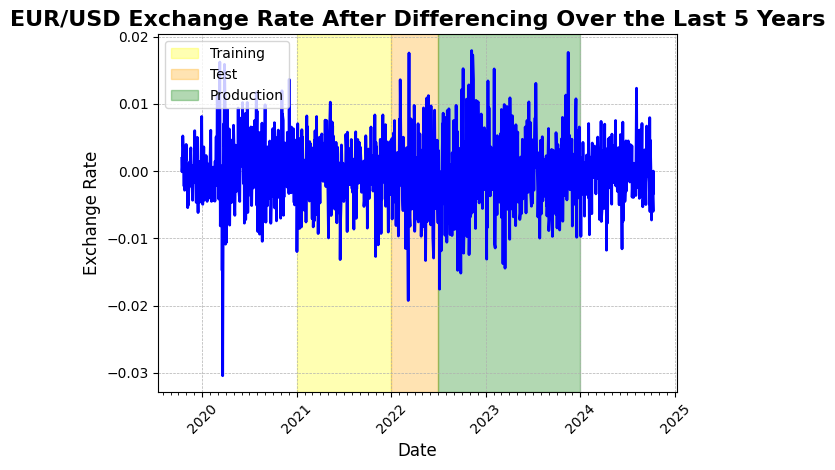

In [6]:

plt.plot(temp_data.index, temp_data, color='blue', linewidth=2)

# Highlighting the years and periods
plt.axvspan(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-31'), color='yellow', alpha=0.3, label='Training')
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-06-30'), color='orange', alpha=0.3, label='Test')
plt.axvspan(pd.Timestamp('2022-07-01'), pd.Timestamp('2023-12-31'), color='green', alpha=0.3, label='Production')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add titles and labels
plt.title('EUR/USD Exchange Rate After Differencing Over the Last 5 Years', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Customize gridlines and ticks
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
class FracDiffLayer(tf.keras.layers.Layer):
    def __init__(self, window_size, d=1.0, **kwargs):
        super(FracDiffLayer, self).__init__(**kwargs)
        self.window_size = window_size
        self.initial_d = d
        self.d = None  # We will initialize this later based on the number of features

    def build(self, input_shape):
        num_features = input_shape[-1]
        # Initialize d as a trainable vector for each feature
        self.d = self.add_weight(
            name='frac_diff_d',
            shape=(num_features,),
            initializer=tf.keras.initializers.Constant(self.initial_d),
            trainable=True,
            dtype=tf.float32
        )
        super(FracDiffLayer, self).build(input_shape)

    def round_to_nearest(self, x, multiple):
        return tf.round(x / multiple) * multiple

    def apply_constraints(self):
        # Clip d to be within [0, 2] and round to the nearest 0.05 increment
        clipped_d = tf.clip_by_value(self.d, 0.55, 2.0)
        rounded_d = self.round_to_nearest(clipped_d, 0.001)
        self.d.assign(rounded_d)

    def process_window(self, inputs, weights_ffd, batch_size, i, num_features):
        start_idx = tf.stack([0, i, 0])
        size = tf.stack([batch_size, self.window_size, num_features])
        window_data = tf.slice(inputs, start_idx, size)
        weighted_window_data = tf.multiply(window_data, weights_ffd)
        window_result = tf.reduce_sum(weighted_window_data, axis=1, keepdims=True)
        return window_result

    def call(self, inputs):

        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        num_features = tf.shape(inputs)[2]

        # Calculate the weights for each feature separately
        weights_ffd = tf.map_fn(lambda d: self.get_weights_ffd(d, self.window_size), self.d, fn_output_signature=tf.float32)

        # Reshape weights_ffd for broadcasting
        weights_ffd_reshaped = tf.reshape(weights_ffd, (1, self.window_size, num_features))

        # Broadcast weights across the batch dimension
        weights_ffd = tf.broadcast_to(weights_ffd_reshaped, (batch_size, self.window_size, num_features))

        indices = tf.range(time_steps - self.window_size + 1)

        # Use the process_window function as a method instead of a nested function
        result = tf.map_fn(lambda i: self.process_window(inputs, weights_ffd, batch_size, i, num_features), indices, fn_output_signature=tf.float32)

        return tf.reshape(result, (batch_size, time_steps - self.window_size + 1, num_features))

    def get_weights_ffd(self, d, window_size):
        w, k = [1.], 1
        for _ in range(window_size - 1):
            w_ = -w[-1] / k * (d - k + 1)
            w.append(w_)
            k += 1

        return tf.convert_to_tensor(w, dtype=tf.float32)

In [8]:
look_back=60
generator_test = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data['Close'].values.astype(float),
        targets=data['Close'].values.astype(float),
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=64,
        shuffle=False,
        seed=None,
        # start_index=len(self.data)-int(6*24*60/15) #should be consistent to the hold out period during model retraining
    )

In [9]:
for i in np.arange(0.0, 1, 0.1):
    print(f'Using d={i}')
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(look_back, 1)),  # Assuming 2 features and 4 time steps
        FracDiffLayer(window_size=look_back, d=i)
    ])

    model.compile(optimizer='adam', loss='mse')

    with tf.device('/CPU:0'):
        output = model.predict(generator_test)

    data['output']=None
    data.iloc[:-look_back+1, data.columns.get_loc('output')] = output[:, -1, :].reshape(len(output))

    result = adfuller(data['output'].dropna())
    p_value = result[1]
    print(p_value)

    if p_value<0.05:
        break


Using d=0.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
0.5277672560632757
Using d=0.1
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step
0.42351883486857783
Using d=0.2
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step
0.18557096628976683
Using d=0.30000000000000004
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
0.06511752817227871
Using d=0.4
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
0.004846983782108852


In [10]:
temp_data = data['output'].dropna()

adf_result = adfuller(temp_data, regression='ctt')
# Assigning the values to variables for clarity
test_statistic = adf_result[0]
p_value = adf_result[1]
used_lag = adf_result[2]
n_obs = adf_result[3]
critical_values = adf_result[4]
ic_best = adf_result[5]

# Printing the results
print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)
print("Number of Lags Used:", used_lag)
print("Number of Observations:", n_obs)
print("Critical Values:", critical_values)
print("Maximized Information Criterion:", ic_best)

plt.figure(figsize=(12, 6))

ADF Test Statistic: -4.061816614665342
p-value: 0.026340940981512347
Number of Lags Used: 10
Number of Observations: 1234
Critical Values: {'1%': -4.380544462003495, '5%': -3.837184083657614, '10%': -3.5562291499534284}
Maximized Information Criterion: -9417.783176868968


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

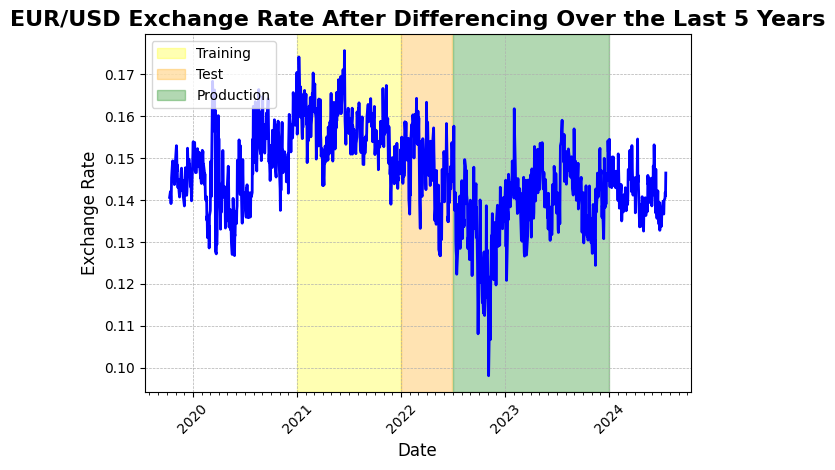

In [11]:

plt.plot(temp_data.index, temp_data, color='blue', linewidth=2)

# Highlighting the years and periods
plt.axvspan(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-31'), color='yellow', alpha=0.3, label='Training')
plt.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-06-30'), color='orange', alpha=0.3, label='Test')
plt.axvspan(pd.Timestamp('2022-07-01'), pd.Timestamp('2023-12-31'), color='green', alpha=0.3, label='Production')

# Formatting the date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Add titles and labels
plt.title('EUR/USD Exchange Rate After Differencing Over the Last 5 Years', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Customize gridlines and ticks
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()